<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/Revised_NN_predict_v29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [37]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# Importing necesary libraries
# Libraries for correct code execution 
import os, time, joblib, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path
import tensorflow

from sdv import SDV
from sdv.tabular import GaussianCopula
from sklearn.metrics import r2_score
from scipy import stats
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [39]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [40]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Get working_df

## Find cutoff index

In [41]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [42]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [43]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  #agg_df = aggreagator_v2(df)
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [44]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [45]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  working_df = pd.merge(extra_info_df, data_df, left_index=True, right_index=True)
  return working_df

In [46]:
def main_cutoff(input_path, manual_cutoff=(False, 0.05)):
  print('Reading data from file...')

  data = io.BytesIO(open(input_path, 'rb').read())
  df = pd.read_excel(data, sheet_name='Sheet1', skiprows=1)
  print('Cleaning data...')
  #df.iloc[0].fillna(method='bfill', inplace=True)
  #df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)

  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  df = df.dropna() # remove nan rows

  if manual_cutoff[0] == False:
    cut_point = cut_off_idx(df)
  else:
    #df = aggreagator_v2(df)
    amt_col = df.shape[1]
    m_cutoff_lower = int(amt_col*manual_cutoff[1])
    m_cutoff_upper = int(amt_col-(amt_col*manual_cutoff[1]))
    cut_point = (m_cutoff_lower, m_cutoff_upper)
  working_df = select_working_data(df, cut_point)

  return working_df

## Run main cutoff

In [47]:
'''
input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"

working_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))
working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)
display(working_df)
'''

'\ninput_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"\n\nworking_df = main_cutoff(input_path, manual_cutoff=(True, 0.1))\nworking_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)\ndisplay(working_df)\n'

# New bootstrap

In [48]:
# !pip install sdv

In [49]:
def train_bootstrap_model(data, distances):
  print('Training synthetic data models...')
  for d in tqdm(distances):
    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    distance_data_df = dist_filtered_working_df.iloc[:, 6:dist_filtered_working_df.shape[1]]

    model = GaussianCopula()
    model.fit(distance_data_df)
    model.save(path+'/Spectrum/NN/revised_bootstrap_models/model_'+str(d)+'.pkl')
  print('Done')

In [50]:
def generate_new_data(data, amt_desired_data, distances, model_path):
  print('Generating synthetic data samples...')
  headers = list(data.columns)
  loop_cnt = 1
  for d in tqdm(distances):
    loaded_model = SDV.load(model_path+'model_'+str(d)+'.pkl')

    dist_filtered_working_df = data.query('Distance_km == '+str(d))
    dist_filtered_working_df.drop(['PBRS_id'], axis = 1, inplace=True)
    seq = [x for x in range(1, dist_filtered_working_df.shape[0]+1)]
    dist_filtered_working_df.insert(0, 'PBRS_id', seq)

    amt_of_samples_dist = dist_filtered_working_df.shape[0]
    amt_of_new_data = amt_desired_data - amt_of_samples_dist

    if amt_of_new_data > 0: # check if we already have the desired amt of samples
      sample = loaded_model.sample(amt_of_new_data)

      row_data = []
      PBRS_id_data = []
      Distance_km_data = []
      power_dBm_data = []
      span_data = []
      extra_h = ['row', 'PBRS_id', 'Channels', 'Distance_km', 'power_dBm', '#span']
      new_data = {header:[] for header in extra_h}
      id_cnt = dist_filtered_working_df['PBRS_id'].max()+1
      # Create extra info columns
      for i in range(0, amt_of_new_data):
        new_data['row'].append(i+1)
        new_data['PBRS_id'].append(int(id_cnt))
        id_cnt += 1
        new_data['Channels'].append(1)
        new_data['Distance_km'].append(int(d))
        new_data['power_dBm'].append(0)
        new_data['#span'].append(int(d/80))
      new_data_extra_info_df = pd.DataFrame.from_dict(new_data)

      new_data_full_df = pd.merge(new_data_extra_info_df, sample, left_index=True, right_index=True)
      if loop_cnt == 1:
        new_working_df = data.append(new_data_full_df)
        loop_cnt+=1
      else:
        new_working_df = new_working_df.append(new_data_full_df)

    else:
      new_working_df = data.copy()
      print('Amount of desired data already satisfied for distance '+str(d)+'.')


  new_working_df.drop(['row'], axis = 1, inplace=True)

  new_working_df['Distance_km'] = new_working_df['Distance_km'].astype(int)
  new_working_df['PBRS_id'] = new_working_df['PBRS_id'].astype(int)
  new_working_df['Channels'] = new_working_df['Channels'].astype(int)
  new_working_df['power_dBm'] = new_working_df['power_dBm'].astype(int)
  new_working_df['#span'] = new_working_df['#span'].astype(int)

  seq = [x for x in range(1, new_working_df.shape[0]+1)]
  new_working_df.insert(0, 'row', seq)
  new_working_df = new_working_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  new_working_df.to_csv(path + "/Spectrum/NN/revised_bootstraped_new_data_working_df-"+str(amt_desired_data)+"_samples.csv", index=False)

  return new_working_df

In [51]:
'''
distances = [x*80 for x in range(1, 26)]

train_bootstrap_model(working_df, distances)
'''

'\ndistances = [x*80 for x in range(1, 26)]\n\ntrain_bootstrap_model(working_df, distances)\n'

In [52]:
'''
input_path = path + "/Spectrum/NN/new_data_working_df.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

amt_desired_data = 250
distances = [x*80 for x in range(1, 26)]
model_path = path+'/Spectrum/NN/revised_bootstrap_models/'

new_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)
new_working_df
'''

'\ninput_path = path + "/Spectrum/NN/new_data_working_df.csv"\nworking_df = pd.read_csv(input_path)\nworking_df[\'Distance_km\'] = working_df[\'Distance_km\'].astype(int)\n\namt_desired_data = 250\ndistances = [x*80 for x in range(1, 26)]\nmodel_path = path+\'/Spectrum/NN/revised_bootstrap_models/\'\n\nnew_working_df = generate_new_data(working_df, amt_desired_data, distances, model_path)\nnew_working_df\n'


# New version train test split

## Freq filter

In [53]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0,1]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  split_span = int(span_val/2)
  span_increase = 0
  for i in range(0, num_selected_freq):
    if i == 0 :
      df2 = data_df.iloc[:, split_span].to_frame()
      new_df = df2
      span_increase = split_span + span_val
    else:
      df2 = data_df.iloc[:, span_increase].to_frame()
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
      span_increase = span_increase + span_val
  new_df = info_df.join(new_df)
  
  return new_df

def get_data(working_df, distances, num_features = 20, span_length=80, min_dist = 0, max_dist = 2000):
  X=None
  Y=np.array([])
  id_df = working_df.iloc[:, 1]
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]

  id_dist_df = pd.merge(id_df, dist_df, left_index=True, right_index=True)
  samples_df = pd.merge(id_dist_df, freq_df, left_index=True, right_index=True)

  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 1].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 2:samples_df.shape[1]]
  
  return X, Y, samples_df

In [54]:
'''
distances = [x*80 for x in range(1, 26)]
X, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)
samples_filtered_df
'''

'\ndistances = [x*80 for x in range(1, 26)]\nX, Y, samples_filtered_df = get_data(working_df, distances, num_features = 20, span_length=80,  min_dist = 0, max_dist = 2000)\nsamples_filtered_df\n'

## Reference split

In [55]:
def get_reference_and_sample_data_split(samples_filtered_df, num_reference=30):
  import random
  num_of_ids = len(samples_filtered_df['PBRS_id'].unique())

  l = list(range(1, num_of_ids+1))
  random.shuffle(l)
  reference_arr = (l[:num_reference]) # selecting first "num_reference" random values
  sample_arr = l[-(num_of_ids-num_reference):]

  reference_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(reference_arr)]
  sample_data_df = samples_filtered_df[samples_filtered_df['PBRS_id'].isin(sample_arr)]
  reference_data_df = reference_data_df.sort_values(by='PBRS_id')
  sample_data_df = sample_data_df.sort_values(by='PBRS_id')

  reference_data_df = reference_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])
  sample_data_df = sample_data_df.sort_values(['PBRS_id', 'Distance_km'], ascending=[True, True])

  return reference_data_df, sample_data_df

In [56]:
#reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=30)
#sample_freq_data_df

## features calc

In [142]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(range(0, sample_freq_data_df.shape[0])):
    data_Y = sample_freq_data_df.iloc[row_idx,1] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,2:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()
  
    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,2:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  if ci == False:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max}
  else:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max,
                    'delta_CI_min':data_CI_lower,
                    'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)
  #new_df = pd.merge(new_df, data_df, left_index=True, right_index=True)
  return data_df

In [58]:
'''
test_references_params=(False, [80, 1040, 2000])

features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)
features_df
'''

'\ntest_references_params=(False, [80, 1040, 2000])\n\nfeatures_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params)\nfeatures_df\n'

## train_test split

In [59]:
def train_and_test_split_funct(features_df, test_size=0.2):
  x_train, x_test, y_train, y_test = train_test_split(features_df.values[:, 1:features_df.values.shape[1]], features_df.values[:, 0], test_size=test_size, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)
  
  joblib.dump(data_scaler, path+'/Spectrum/NN/revised_NNs/scaler_nn.joblib')

  return x_train, y_train, x_test, y_test, data_scaler

In [60]:
#x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=0.2)

## main features train_test

In [61]:
def magic_calc(working_df, magic_num=0.2):
  distances = [x*80 for x in range(1, 26)]
  val_add = 1
  headers = list(working_df.columns)
  extra_h = ['row', 'PBRS_id', 'Channels', 'Distance_km', 'power_dBm', '#span']
  for hh in extra_h:
    headers.remove(hh)

  for d in distances:
    n_w_df = working_df.query('Distance_km == '+str(d))
    for h in headers:
      n_w_df[h] = n_w_df[h].apply(lambda x: x*val_add)
    if d != 80:
      old_n_w_df = old_n_w_df.append(n_w_df)
    else:
      old_n_w_df = n_w_df.copy()
    val_add = val_add + magic_num

  return old_n_w_df

In [168]:
def main_features_train_test_split(input_path, multiplier=5, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=False, split_done=False):
  if split_done == False:
    working_df = pd.read_csv(input_path)
    working_df['Distance_km'] = working_df['Distance_km'].astype(int)
    distances = [x*80 for x in range(1, 26)]

    working_df = magic_calc(working_df, magic_num=multiplier)

    print('Obtaining data filtered by frequencies...')
    X, Y, samples_filtered_df = get_data(working_df, distances, num_features = num_features, span_length=80,  min_dist = 0, max_dist = 2000) # get data filtered by frequencies
    print('Obtaining reference and sample split...')
    #reference_freq_data_df, sample_freq_data_df = get_reference_and_sample_data_split(samples_filtered_df, num_reference=num_reference) # get reference and sample split
    print('Calculating features...')
    #features_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=ci) # get features calc for samples

    samples_filtered_df = samples_filtered_df.iloc[: , 1:]
    print('\nObtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(samples_filtered_df, test_size=test_size) # create train/test split and save scaler
    
    #reference_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #sample_freq_data_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    #features_df.to_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv", header=True, index=False)
    print('Done')

  else:
    reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    features_df = pd.read_csv(path+"/Spectrum/NN/revised_train_test_splits/mod_bootstraped_new_data_Features_NN_freq_"+str(num_features)+"_reference_"+str(num_reference)+".csv")
    print('Obtaining train and test split...')
    x_train, y_train, x_test, y_test, data_scaler = train_and_test_split_funct(features_df, test_size=test_size) # create train/test split and save scaler
    print('Done')
  
  with open(path+'/Spectrum/NN/revised_train_test_splits/data_scaler_nn.pkl', 'wb') as pickle_file:
    pickle.dump(data_scaler, pickle_file)
    
  return x_train, y_train, x_test, y_test, data_scaler#, reference_freq_data_df, sample_freq_data_df


In [63]:
'''
input_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)
'''

'\ninput_path = path + "/Spectrum/NN/bootstraped_new_data_working_df.csv"\n\nx_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(\n    input_path, num_features = 20, num_reference=30, test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=True, split_done=False)\n'

#Test new data

## Test Run

In [64]:
def predict_test(model_ann, X_test, Y_test, remove_outliers=0.05, params_freq_reference = (10, 30), all_plots=True, epochs_num=600, training_data=False, save_res=False):
  print('Results (freq_'+str(params_freq_reference[0])+'_reference_'+str(params_freq_reference[1])+')')
  # Predit

  Y_test_pred=model_ann.predict(X_test)

  dist_min=80
  dist_max=2000

  real=list(Y_test)
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred=list(Y_test_pred)
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  '''
  print('Real_abs:')
  print(real_abs)
  print('Pred_abs:')
  print(pred_abs)
  '''
  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  num_of_remove_items = len(real) * remove_outliers

  filtered_real_abs = real_abs
  filtered_pred_abs = pred_abs
  error_v2_filtered = error_v2
  error_filtered = error
  remove_cnt = 0
  while remove_cnt <= num_of_remove_items:
    max_idx = np.where(error_v2_filtered == np.amax(error_v2_filtered))
    max_idx = max_idx[0][0]
    error_v2_filtered = np.delete(error_v2_filtered, max_idx)
    filtered_real_abs = np.delete(filtered_real_abs, max_idx)
    filtered_pred_abs = np.delete(filtered_pred_abs, max_idx)
    error_filtered = np.delete(error_filtered, max_idx)
    remove_cnt += 1

  if all_plots == True:
    if save_res == True:
      res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
      res.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)

      res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
      res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".csv", header=True, index=False)
      
      plt.plot(real_abs,error,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Curve (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/mod_bootstraped_new_data_results_curve_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
      
      plt.plot(real_abs,error_v2,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Deltas (freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")

      # Filtered Outliers
      plt.plot(filtered_real_abs,error_v2_filtered,'bo')
      plt.xlabel('Distances') 
      plt.ylabel('Error') 
      plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
      plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+".png")
      plt.show()
  else:
    res_v2=pd.DataFrame({"dist":filtered_real_abs,"pred":filtered_pred_abs,"error":error_v2_filtered})
    # Filtered Outliers
    plt.figure(figsize=(20,10))
    plt.plot(filtered_real_abs,error_v2_filtered,'bo')
    plt.xlabel('Distances')
    labels = [i*80 for i in range(1, 26)]
    plt.xticks(labels)
    #plt.yticks(labels) 
    plt.ylabel('Error') 
    plt.title("Results Deltas Filtered (Outliers_Removed_"+str(remove_outliers*100)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+")")
    if save_res == True:
      if training_data == False:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Testing_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")   
      else:
        res_v2.to_csv(path+"/Spectrum/NN/revised_NN_results_error/mod_bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".csv", header=True, index=False)
        plt.savefig(path+"/Spectrum/NN/revised_NN_results_plots/bootstraped_new_data_Training_results_deltas_filtered_"+str(remove_outliers)+"%_freq_"+str(params_freq_reference[0])+"_reference_"+str(params_freq_reference[1])+"_epochs_"+str(epochs_num)+".png")
    plt.show()

  return error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs

In [161]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 2054, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  l = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
  m = tf.keras.metrics.MeanSquaredError()
  model.compile(loss =l, optimizer = opt, metrics = m)
  return model

def train_model(X_train, Y_train, num_of_freq_selected, reference_amt):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  model_ann = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)

  callback = [EarlyStopping(monitor='loss', patience=30)]#, TqdmCallback(verbose=2)]
  history = model_ann.fit(X_train, Y_train,  validation_split = 0.2, callbacks=callback)
  
  history_dict=history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']

  plt.figure()
  plt.plot(loss_values,'bo',label='training loss')
  plt.plot(val_loss_values,'r',label='val training loss')
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['training loss', 'val training loss'], loc='best')

  # Save model
  pickle.dump(model_ann,open(path+"/Spectrum/NN/revised_NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))
  model_ann.model.save(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [169]:
input_path = path + "/Spectrum/NN/revised_bootstraped_new_data_working_df.csv"

ci = False # include or exclude CI calc
parameters_freq_reference = ('all', 30) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler = main_features_train_test_split(
    input_path, multiplier=1, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, 80), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...

Obtaining train and test split...
Done


Training model (freq_all_reference_30)...
INFO:tensorflow:Assets written to: ram://54170779-8295-40f5-9fc4-140c0c37a1ae/assets
Results (freq_all_reference_30)


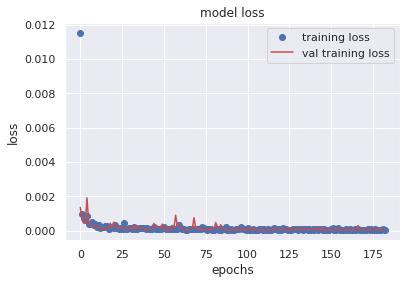

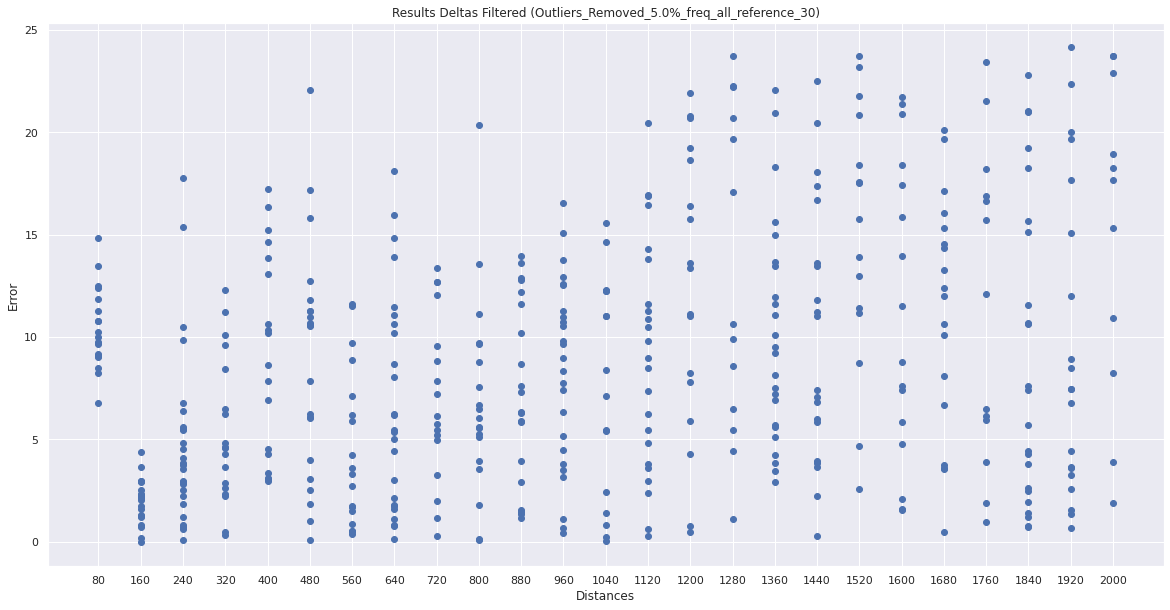

In [170]:
model_ann = train_model(x_train, y_train_norm, parameters_freq_reference[0], parameters_freq_reference[1])
error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(model_ann, x_test, y_test_norm, remove_outliers=0.05, params_freq_reference = parameters_freq_reference, 
                                                                                       all_plots=False, epochs_num='test', training_data=False, save_res=False)

In [ ]:

y_train_pred = model_ann.predict(x_train)
y_test_pred = model_ann.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train_norm, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test_norm, y_test_pred)))

df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))

df.query('actual == 1.0')


The R2 score on the Train set is:	0.996
The R2 score on the Test set is:	0.996


,actual,pred,error
9,1.0,1.005850,-0.005850
19,1.0,0.992057,0.007943
79,1.0,0.990208,0.009792
84,1.0,0.980295,0.019705
107,1.0,1.009741,-0.009741
109,1.0,0.976416,0.023584
110,1.0,0.983363,0.016637
177,1.0,0.965497,0.034503
178,1.0,0.999577,0.000423
181,1.0,0.976576,0.023424


In [ ]:

#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')


,actual,pred,error
9,2000.0,2011.232422,-11.232422
19,2000.0,1984.749634,15.250366
79,2000.0,1981.199463,18.800537
84,2000.0,1962.167358,37.832642
107,2000.0,2018.702393,-18.702393
109,2000.0,1954.719360,45.280640
110,2000.0,1968.057373,31.942627
177,2000.0,1933.753906,66.246094
178,2000.0,1999.188721,0.811279
181,2000.0,1955.025879,44.974121


## random search

In [ ]:
!pip install keras-tuner -q

In [ ]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from tensorflow.keras import optimizers

In [ ]:
input_path = path + "/Spectrum/NN/revised_bootstraped_new_data_working_df.csv"

ci = False # include or exclude CI calc
parameters_freq_reference = (100, 50) #(num_frequencies, num_references)

x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
    input_path, multiplier=5, num_features = parameters_freq_reference[0], num_reference=parameters_freq_reference[1], 
    test_size=0.2, test_references_params=(False, [80, 1040, 2000]), ci=ci, split_done=False)

y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

# inverted_x_test = scaler.inverse_transform(x_test)



Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


100%|██████████| 1245/1245 [00:59<00:00, 20.99it/s]



Obtaining train and test split...
Done


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(hp.Int('units_0', min_value=9, max_value=512, step=16), input_dim = 5, activation="tanh"))
    for i in range(1, hp.Int('num_layers', 1, 8)):
        model.add(
            tf.keras.layers.Dense(
                # Tune number of units separately.
                units=hp.Int('units_' + str(i), min_value=9, max_value=512, step=16),
                activation="tanh"),
        )
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

In [ ]:
import os.path 
for i in range(0, 20):
  tunner_path = path+"/Spectrum/NN/revised_NNs/tunner_search_"+str(i)
  isdir = os.path.isdir(tunner_path) 
  if isdir == False:
    dir_tunner = tunner_path
    break

tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory=dir_tunner,
    project_name='Dist predictor')
tuner.search_space_summary()

Search space summary
Default search space size: 3
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 9, 'max_value': 512, 'step': 16, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
print('Evaluating hyperparameters...')
tuner.search(x_train, y_train_norm,
             epochs=200,
             validation_data=(x_test, y_test_norm), verbose=0)
print('Done')

print('-------------------------------------')
tuner.results_summary()

Evaluating hyperparameters...
INFO:tensorflow:Oracle triggered exit
Done
-------------------------------------
Results summary
Results in /content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset/Spectrum/NN/revised_NNs/tunner_search_3/Dist predictor
Showing 10 best trials
Trial summary
Hyperparameters:
units_0: 377
num_layers: 2
learning_rate: 0.0001
units_1: 9
Score: 0.00026394119292187196
Trial summary
Hyperparameters:
units_0: 169
num_layers: 2
learning_rate: 0.0001
units_1: 89
units_2: 265
units_3: 297
units_4: 25
units_5: 57
Score: 0.000267195311607793
Trial summary
Hyperparameters:
units_0: 217
num_layers: 6
learning_rate: 0.01
units_1: 505
units_2: 9
units_3: 9
units_4: 9
units_5: 9
Score: 0.05885779787786305
Trial summary
Hyperparameters:
units_0: 121
num_layers: 5
learning_rate: 0.01
units_1: 249
units_2: 281
units_3: 345
units_4: 89
units_5: 313
Score: 0.08709527800480525
Trial summary
Hyperparameters:
units_0: 41
num_layers: 5
learning_rate: 0.01
units_1: 25
units_2: 297
units

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(5))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 377)               2262      
                                                                 
 dense_1 (Dense)             (None, 9)                 3402      
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 5,674
Trainable params: 5,674
Non-trainable params: 0
_________________________________________________________________


## test model

------------------Trainig------------------
Epoch 41: early stopping
The R2 score on the Train set is:	-3.154
The R2 score on the Test set is:	-3.320


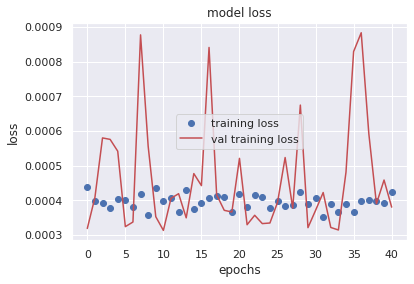

In [ ]:
#Fits model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
print('------------------Trainig------------------')
history = best_model.fit(x_train, y_train_norm, epochs = 5000, validation_split = 0.2, batch_size=32, callbacks = [earlystop], shuffle = True, verbose = 0)
history_dict=history.history

#Plots model's training cost/loss and model's validation split cost/loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure()
plt.plot(loss_values,'bo',label='training loss')
plt.plot(val_loss_values,'r',label='val training loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training loss', 'val training loss'], loc='best')

# Runs model (the one with the activation function, although this doesn't really matter as they perform the same) 
# with its current weights on the training and testing data
y_train_pred = best_model.predict(x_train)
y_test_pred = best_model.predict(x_test)

# Calculates and prints r2 score of training and testing data
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_test_pred)))

# train best than test overfitting

In [ ]:
# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_norm, columns=['actual'])
df.insert(1, 'pred', y_test_pred)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 1.0')

,actual,pred,error
37,1.0,0.982011,0.017989
50,1.0,1.044691,-0.044691
52,1.0,0.994944,0.005056
62,1.0,0.993511,0.006489
66,1.0,0.992595,0.007405
117,1.0,1.029213,-0.029213
164,1.0,1.014665,-0.014665
172,1.0,0.991266,0.008734
209,1.0,0.977886,0.022114
243,1.0,1.020091,-0.020091


In [ ]:
#denorm = (norm * (2000-80)+80)

y_test_denorm = (y_test_norm * (2000-80)+80)
y_test_pred_denorm = (y_test_pred * (2000-80)+80)

# inverted_x_test = scaler.inverse_transform(x_test)
df = pd.DataFrame(y_test_denorm, columns=['actual'])
df.insert(1, 'pred', y_test_pred_denorm)
df.insert(2, 'error', (df.actual-df.pred))
df.query('actual == 2000.0')

,actual,pred,error
37,2000.0,1965.461670,34.538330
50,2000.0,2085.807373,-85.807373
52,2000.0,1990.293091,9.706909
62,2000.0,1987.542114,12.457886
66,2000.0,1985.782471,14.217529
117,2000.0,2056.089844,-56.089844
164,2000.0,2028.157715,-28.157715
172,2000.0,1983.230469,16.769531
209,2000.0,1957.540405,42.459595
243,2000.0,2038.575073,-38.575073


# Validation

In [ ]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  if test_references_params[0] == True: # Test reference distance portion
    reference_freq_data_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == test_references_params[1]]

  for row_idx in tqdm(range(0, sample_freq_data_df.shape[0])):
    data_Y = sample_freq_data_df.iloc[row_idx,1] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,2:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data -----------------
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.empty:
      distance_reference_df = reference_freq_data_df.copy()

    pearson_vals = []
    confidence_vals_lower = []
    confidence_vals_upper = []
    for reference_row in range(0, distance_reference_df.shape[0]):
      reference_X = np.array(distance_reference_df.iloc[reference_row,2:distance_reference_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(round(abs(reference_confidence_int_lower - data_confidence_int_lower), 5))
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(round(abs(reference_confidence_int_upper - data_confidence_int_upper),5))

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(np.min(confidence_vals_lower))
    data_CI_upper.append(np.min(confidence_vals_upper))

  if ci == False:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max}
  else:
    data = {'distance':data_distance,
                    'mean':data_mean,
                    'std':data_std,
                    'pearson_min':data_pearson_min,
                    'pearson_mean':data_pearson_mean,
                    'pearson_max':data_pearson_max,
                    'delta_CI_min':data_CI_lower,
                    'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

In [ ]:
train_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_training_data_NN_freq_10_reference_30.csv")
test_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_testing_data_NN_freq_10_reference_30.csv")

reference_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Reference_NN_freq_10_reference_30.csv")
sample_freq_data_df = pd.read_csv(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_new_data_Sample_NN_freq_10_reference_30.csv")

with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_traininig_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_training = pickle.load(f)
with open(path+"/Spectrum/NN/train_test_splits/mod_bootstraped_testing_Rows_NN_freq_10_reference_30.pkl", 'rb') as f:
  rows_testing = pickle.load(f) 

In [ ]:
num_of_freq_selected = 10
reference_amt = 30

# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=8, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/revised_NNs/pearson_new_data_NN_model_freq_100_reference_50.h5")

res = {}
reference_test = [80, 1040, 2000]
distances = [x*80 for x in range(1, 26)]

for r in reference_test:
  test_references_params = (True, r)
  #new_test_df = get_features_funct(sample_freq_data_df, reference_freq_data_df, test_references_params, ci=False)
  input_path = path + "/Spectrum/NN/revised_bootstraped_new_data_working_df-250_samples.csv"

  x_train, y_train, x_test, y_test, data_scaler, reference_freq_data_df, sample_freq_data_df = main_features_train_test_split(
      input_path, num_features = 100, num_reference=50, test_size=0.2, test_references_params=(True, [r]), ci=False, split_done=False)

  #new_test_df = test_df.copy()
  
  dist_min=80 # 80
  dist_max=2000 # 2000

  y_train_norm = (y_train - y_train.min())/ (y_train.max() - y_train.min())
  y_test_norm = (y_test - y_test.min())/ (y_test.max() - y_test.min())

  error_filtered, error_v2_filtered, filtered_real_abs, filtered_pred_abs = predict_test(mm, x_test, y_test, remove_outliers=0.05, 
                                                                                         params_freq_reference = (100, 50), all_plots=False, epochs_num='test', training_data=False, save_res=False)
 
  res[r] = filtered_pred_abs
print('-----------------------------------------------------------------------')
print('Resuslts')

plt.figure(figsize=(15, 10))
plt.plot(distances, distances,  linestyle='--')
for re in reference_test:
  plt.plot(distances, res[re], label='Reference '+str(re))

plt.title('Real vs Predicted Distances')
plt.xlabel('Real Distances')
plt.ylabel('Predicted Distances')
plt.xlim(np.min(distances)-25, np.max(distances)+25)
plt.ylim(np.min(distances)-25, np.max(distances)+25)
plt.yticks(distances)
plt.xticks(distances)
plt.legend(loc="best")
plt.show()

#y_test_denorm = (y_test_norm * (2000-80)+80)
#y_test_pred_denorm = (y_test_pred * (2000-80)+80)

for re in reference_test:
  print(res[re])

print('-----------------------------------------------------------------------')

Obtaining data filtered by frequencies...
Obtaining reference and sample split...
Calculating features...


ValueError: ignored